In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
print(os.listdir("../input"))

Using TensorFlow backend.


['aslselfmod', 'asl-alphabet']


**Replacing kaggle dataset with self generated set randomly**

In [3]:
os.mkdir("dump")

In [4]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
newt = '../input/aslselfmod/train'
dump = 'dump'

import random
from shutil import copy

for al in os.listdir(train_dir):
    tal = os.path.join(train_dir,al)
    ntal = os.path.join(newt,al)
    ndir = dump +'/'+al
    os.mkdir(ndir)
    #print(al,len(os.listdir(tal)))
    
    nt = os.listdir(ntal)
    s = random.sample(os.listdir(tal),350)
    
    for im in os.listdir(tal):
        if im in s:
            src = os.path.join(ntal,nt.pop())
        else:
            src = os.path.join(tal,im)
        dst = os.path.join(ndir,im)
        #print(src,dst)
        copy(src,dst)
    print(al)

N
I
U
P
Y
Z
H
C
B
del
D
T
M
K
Q
F
G
nothing
E
X
S
L
A
V
space
W
R
J
O


In [5]:
train_dir = 'dump'

for al in os.listdir(train_dir):
    tal = os.path.join(train_dir,al)
    print(al,len(os.listdir(tal)))

K 3000
C 3000
R 3000
S 3000
U 3000
N 3000
L 3000
del 3000
Z 3000
W 3000
B 3000
E 3000
V 3000
I 3000
X 3000
J 3000
D 3000
M 3000
P 3000
Q 3000
space 3000
H 3000
F 3000
A 3000
T 3000
G 3000
Y 3000
O 3000
nothing 3000


**Labels and Image samples**

unique_labels =  ['K', 'C', 'R', 'S', 'U', 'N', 'L', 'del', 'Z', 'W', 'B', 'E', 'V', 'I', 'X', 'J', 'D', 'M', 'P', 'Q', 'space', 'H', 'F', 'A', 'T', 'G', 'Y', 'O', 'nothing']


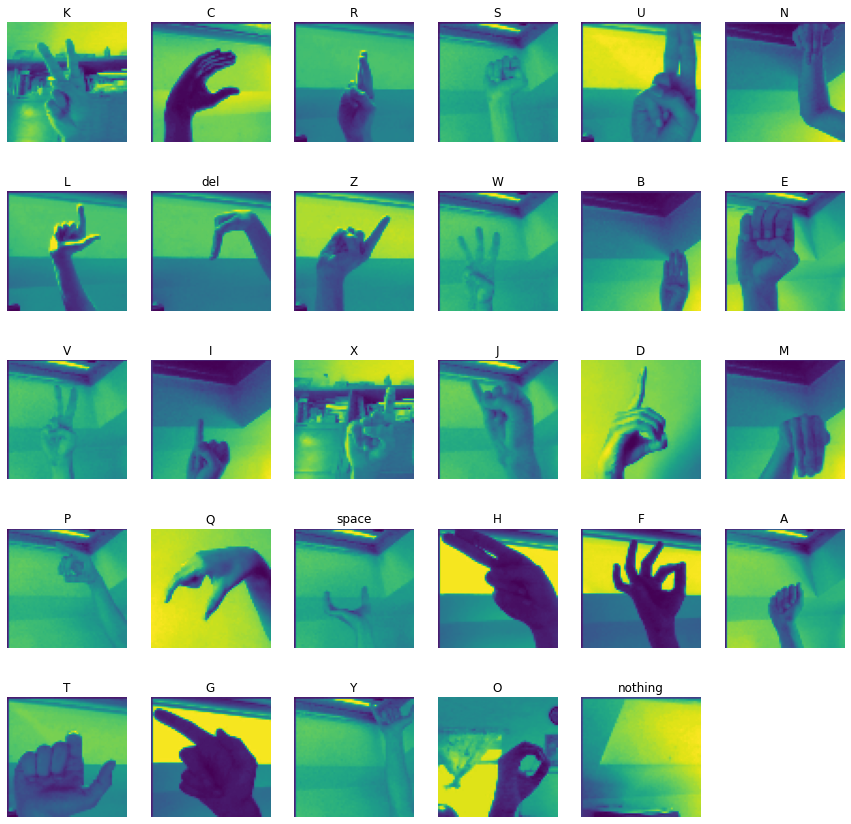

In [6]:
def load_unique():
    size_img = 64,64 
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath,0)
            final_img = cv2.resize(image, size_img)
            #final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

**Loading Training and testing set**

In [7]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.cvtColor(temp_img,cv2.COLOR_BGR2GRAY)
            temp_img = cv2.resize(temp_img, size)
            temp_img = np.reshape(temp_img,(64,64,1))
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [8]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : K | C | R | S | U | N | L | del | Z | W | B | E | V | I | X | J | D | M | P | Q | space | H | F | A | T | G | Y | O | nothing | 
Loaded 82650 images for training, Train data shape = (82650, 64, 64, 1)
Loaded 4350 images for testing Test data shape = (4350, 64, 64, 1)


#### Loading Layers
Using Maxpooling,Dropout and Batch normaliazation

In [9]:
def create_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,1)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(29, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model.summary()
    
    return model


def fit_model():
    model_hist = model.fit(X_train, Y_train, batch_size = 64, epochs = 5, validation_split = 0.1)
    return model_hist 


In [10]:
model = create_model()
curr_model_hist = fit_model()

MODEL CREATED
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7

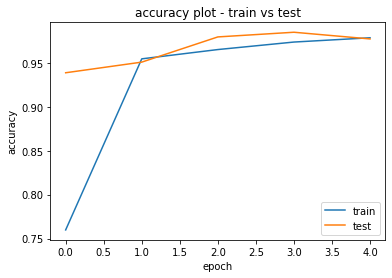

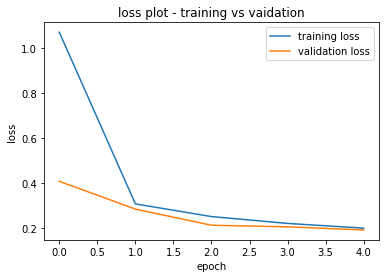

In [11]:
plt.plot(curr_model_hist.history['accuracy'])
plt.plot(curr_model_hist.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(curr_model_hist.history['loss'])
plt.plot(curr_model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

4350/4350 [==============================] - 1s 120us/step

Evaluation Accuracy =  97.98% 
Evaluation loss =  0.183937


In [13]:
model.save('kagg_aslmod2_gray.h5')